[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_cmnd_tutorial.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Comparison with scikit-learn's GaussianMixture

In this notebook, we compare **MultiMin's CMND** with **scikit-learn's GaussianMixture** (GMM) to highlight similarities, differences, and the unique capabilities of each approach.

Both methods fit Gaussian mixture models, but with different philosophies:

- **scikit-learn GMM**: Focused on machine learning tasks, uses Expectation-Maximization (EM) algorithm
- **MultiMin CMND**: Focused on distribution modeling and physics applications, uses direct likelihood optimization

Let's compare them across several dimensions: **syntax**, **performance**, **capabilities**, and **use cases**.

## Installation and importing

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [50]:
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/
# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import multimin as mn
mn.show_watermark = True

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import Markdown, display

import numpy as np
np.random.seed(1)
deg = np.pi/180

import warnings
warnings.filterwarnings("ignore")

figprefix = "gmmcompare"

### Setup: Import and prepare data

First, let's import scikit-learn's GaussianMixture and generate test data:

In [53]:
# Import scikit-learn's GaussianMixture
from sklearn.mixture import GaussianMixture
import time

# Generate test data: mixture of 3 Gaussians in 2D
np.random.seed(42)
n_samples = 1000

# Component 1: centered at (0, 0)
samples1 = np.random.multivariate_normal([0, 0], [[1, 0.3], [0.3, 1]], size=300)
# Component 2: centered at (5, 5)
samples2 = np.random.multivariate_normal([5, 5], [[0.8, -0.2], [-0.2, 0.8]], size=400)
# Component 3: centered at (2, -3)
samples3 = np.random.multivariate_normal([2, -3], [[1.2, 0.5], [0.5, 1.2]], size=300)

# Combine all samples
data_comparison = np.vstack([samples1, samples2, samples3])

print(f"Generated {len(data_comparison)} samples from 3 Gaussian components")
print(f"Data shape: {data_comparison.shape}")

Generated 1000 samples from 3 Gaussian components
Data shape: (1000, 2)


### Comparison 1: Syntax and Fitting

Let's fit the same data with both methods and compare the syntax:

In [57]:
# ==========================================
# FITTING WITH SCIKIT-LEARN GMM
# ==========================================
print("=" * 60)
print("SCIKIT-LEARN GAUSSIANMIXTURE")
print("=" * 60)

# Fit with scikit-learn
t0 = time.time()
gmm_sklearn = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm_sklearn.fit(data_comparison)
time_sklearn = time.time() - t0

print(f"Fitting time: {time_sklearn:.4f} seconds")
print(f"Converged: {gmm_sklearn.converged_}")
print(f"N iterations: {gmm_sklearn.n_iter_}")
print(f"Log-likelihood: {gmm_sklearn.score(data_comparison) * len(data_comparison):.2f}")
print(f"-LogL/N: {-gmm_sklearn.score(data_comparison):.4f}")
print()

# ==========================================
# FITTING WITH MULTIMIN CMND
# ==========================================
print("=" * 60)
print("MULTIMIN CMND")
print("=" * 60)

# Fit with MultiMin
t0 = time.time()
F_comparison = mn.FitCMND(data_comparison, ngauss=3)
F_comparison.fit_data(data_comparison, verbose=0, options={'maxiter': 500})
time_multimin = time.time() - t0

print(f"Fitting time: {time_multimin:.4f} seconds")
print()

# ==========================================
# COMPARISON SUMMARY
# ==========================================
print("=" * 60)
print("COMPARISON")
print("=" * 60)
print(f"Speed ratio (sklearn/multimin): {time_sklearn/time_multimin:.2f}x")
print(f"sklearn is {'faster' if time_sklearn < time_multimin else 'slower'}")
#print(f"-LogL/N difference: {abs(F_comparison.minres.fun - (-gmm_sklearn.score(data_comparison))):.6f}")

SCIKIT-LEARN GAUSSIANMIXTURE
Fitting time: 0.0232 seconds
Converged: True
N iterations: 2
Log-likelihood: -3778.74
-LogL/N: 3.7787

MULTIMIN CMND
Loading a FitCMND object.
Number of gaussians: 3
Number of variables: 2
Number of dimensions: 6
Number of samples: 1000
Log-likelihood per point (-log L/N): 12.117658034849903
Fitting time: 0.3287 seconds

COMPARISON
Speed ratio (sklearn/multimin): 0.07x
sklearn is faster


### Comparison 2: Parameter Access and Inspection

Both methods give access to the fitted parameters, but with different interfaces:

In [58]:
# ==========================================
# SCIKIT-LEARN PARAMETERS
# ==========================================
print("=" * 60)
print("SCIKIT-LEARN PARAMETERS")
print("=" * 60)
print(f"Weights:\n{gmm_sklearn.weights_}")
print(f"\nMeans:\n{gmm_sklearn.means_}")
print(f"\nCovariances shape: {gmm_sklearn.covariances_.shape}")
print()

# ==========================================
# MULTIMIN PARAMETERS
# ==========================================
print("=" * 60)
print("MULTIMIN PARAMETERS")
print("=" * 60)
print(f"Weights:\n{F_comparison.cmnd.weights}")
print(f"\nMeans:\n{F_comparison.cmnd.mus}")
print(f"\nCovariances shape: {F_comparison.cmnd.Sigmas.shape}")
print()

# Note: Parameters may differ due to different initialization and optimization approaches
print("Note: Parameter values may differ between methods due to:")
print("  • Different initialization strategies")
print("  • Different optimization algorithms (EM vs. direct optimization)")
print("  • Label switching (components can be in different orders)")

SCIKIT-LEARN PARAMETERS
Weights:
[0.40003196 0.29985149 0.30011655]

Means:
[[ 4.98308814  5.08712197]
 [ 1.89387311 -2.96269368]
 [ 0.03248888  0.00985545]]

Covariances shape: (3, 2, 2)

MULTIMIN PARAMETERS
Weights:
[0.39955057 0.29919141 0.30125802]

Means:
[[ 4.98308932e+00  5.08712011e+00]
 [ 1.89529243e+00 -2.96671658e+00]
 [ 3.04743275e-02  4.37246329e-03]]

Covariances shape: (3, 2, 2)

Note: Parameter values may differ between methods due to:
  • Different initialization strategies
  • Different optimization algorithms (EM vs. direct optimization)
  • Label switching (components can be in different orders)


### Comparison 3: Visualization

Let's visualize the fits from both methods:

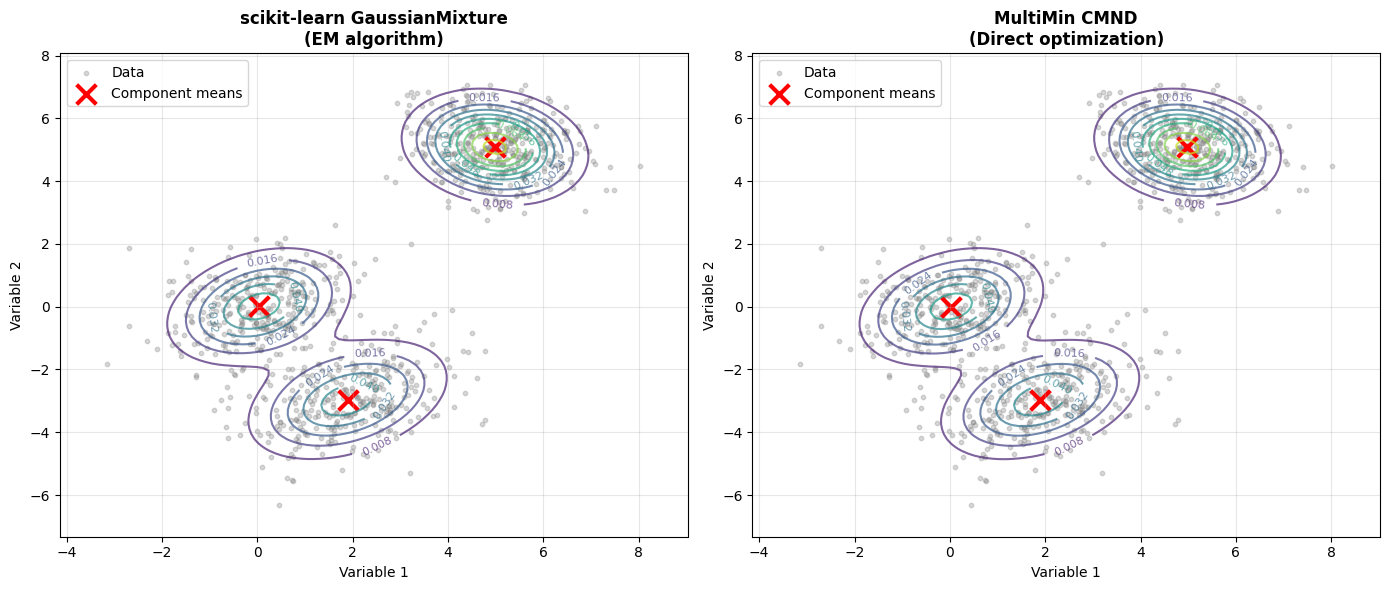

✓ Both methods successfully fit the 3-component mixture


In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Create grid for contour plots
x = np.linspace(data_comparison[:, 0].min() - 1, data_comparison[:, 0].max() + 1, 100)
y = np.linspace(data_comparison[:, 1].min() - 1, data_comparison[:, 1].max() + 1, 100)
X_grid, Y_grid = np.meshgrid(x, y)
grid_points = np.c_[X_grid.ravel(), Y_grid.ravel()]

# ==========================================
# PLOT 1: Scikit-learn GMM
# ==========================================
ax1 = axes[0]
ax1.scatter(data_comparison[:, 0], data_comparison[:, 1], alpha=0.3, s=10, c='gray', label='Data')

# Compute log-likelihood on grid
Z_sklearn = gmm_sklearn.score_samples(grid_points).reshape(X_grid.shape)

# Plot contours
contours1 = ax1.contour(X_grid, Y_grid, np.exp(Z_sklearn), levels=10, cmap='viridis', alpha=0.7)
ax1.clabel(contours1, inline=True, fontsize=8)

# Plot component means
ax1.scatter(gmm_sklearn.means_[:, 0], gmm_sklearn.means_[:, 1], 
           c='red', s=200, marker='x', linewidths=3, label='Component means')

ax1.set_xlabel('Variable 1')
ax1.set_ylabel('Variable 2')
ax1.set_title('scikit-learn GaussianMixture\n(EM algorithm)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# ==========================================
# PLOT 2: MultiMin CMND
# ==========================================
ax2 = axes[1]
ax2.scatter(data_comparison[:, 0], data_comparison[:, 1], alpha=0.3, s=10, c='gray', label='Data')

# Compute PDF on grid using MultiMin
Z_multimin = F_comparison.cmnd.pdf(grid_points).reshape(X_grid.shape)

# Plot contours
contours2 = ax2.contour(X_grid, Y_grid, Z_multimin, levels=10, cmap='viridis', alpha=0.7)
ax2.clabel(contours2, inline=True, fontsize=8)

# Plot component means
ax2.scatter(F_comparison.cmnd.mus[:, 0], F_comparison.cmnd.mus[:, 1], 
           c='red', s=200, marker='x', linewidths=3, label='Component means')

ax2.set_xlabel('Variable 1')
ax2.set_ylabel('Variable 2')
ax2.set_title('MultiMin CMND\n(Direct optimization)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'gallery/{figprefix}_comparison_sklearn_multimin.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Both methods successfully fit the 3-component mixture")

### Comparison 4: Unique Capabilities

Each method has unique features that make it suitable for different use cases:

In [64]:
# ==========================================
# MultiMin UNIQUE FEATURES
# ==========================================
print("=" * 60)
print("MULTIMIN UNIQUE FEATURES")
print("=" * 60)
print()

# Feature 1: Integrated visualization with DensityPlot
print("1. Built-in visualization tools:")
print("   ✓ plot_sample() - visualize data and fitted PDF")
print("   ✓ plot_fit() - comprehensive fit visualization")
print("   ✓ DensityPlot - advanced multi-dimensional plotting")
print()

# Feature 2: Sampling from fitted distribution
print("2. Direct sampling from fitted distribution:")
samples_multimin = F_comparison.cmnd.rvs(1000)
print(f"   ✓ Generated {len(samples_multimin)} samples from CMND")
print(f"   ✓ Sample shape: {samples_multimin.shape}")
print()

# Feature 3: PDF evaluation
print("3. Direct PDF evaluation:")
test_point = np.array([[2.0, 1.0]])
pdf_val = F_comparison.cmnd.pdf(test_point)
print(f"   ✓ PDF at {test_point[0]}: {pdf_val:.6f}")
print()

# Feature 4: Truncated domains
print("4. Truncated domain support:")
print("   ✓ Can fit distributions with bounded domains")
print("   ✓ Useful for physical constraints (e.g., positive-only variables)")
print()

# Feature 5: LaTeX output
print("5. Mathematical representation:")
print("   ✓ get_function(type='python') - Python code")
print("   ✓ get_function(type='latex') - LaTeX equations")
print()

# ==========================================
# SCIKIT-LEARN UNIQUE FEATURES
# ==========================================
print("=" * 60)
print("SCIKIT-LEARN UNIQUE FEATURES")
print("=" * 60)
print()

# Feature 1: Model selection tools
print("1. Built-in model selection:")
from sklearn.model_selection import GridSearchCV
print("   ✓ BIC/AIC for model selection")
print("   ✓ Integration with scikit-learn pipeline")
print()

# Feature 2: Different covariance types
print("2. Multiple covariance types:")
for cov_type in ['full', 'tied', 'diag', 'spherical']:
    gmm_test = GaussianMixture(n_components=3, covariance_type=cov_type, random_state=42)
    gmm_test.fit(data_comparison)
    print(f"   ✓ '{cov_type}': BIC = {gmm_test.bic(data_comparison):.2f}")
print()

# Feature 3: Prediction and classification
print("3. Prediction and classification:")
predictions = gmm_sklearn.predict(data_comparison[:10])
print(f"   ✓ Component assignment: {predictions}")
probs = gmm_sklearn.predict_proba(data_comparison[:10])
print(f"   ✓ Probability matrix shape: {probs.shape}")
print()

# Feature 4: Speed and scalability
print("4. Performance:")
print("   ✓ EM algorithm is generally faster")
print("   ✓ Better suited for very large datasets")
print("   ✓ Mature, optimized implementation")

MULTIMIN UNIQUE FEATURES

1. Built-in visualization tools:
   ✓ plot_sample() - visualize data and fitted PDF
   ✓ plot_fit() - comprehensive fit visualization
   ✓ DensityPlot - advanced multi-dimensional plotting

2. Direct sampling from fitted distribution:
   ✓ Generated 1000 samples from CMND
   ✓ Sample shape: (1000, 2)

3. Direct PDF evaluation:
   ✓ PDF at [2. 1.]: 0.006557

4. Truncated domain support:
   ✓ Can fit distributions with bounded domains
   ✓ Useful for physical constraints (e.g., positive-only variables)

5. Mathematical representation:
   ✓ get_function(type='python') - Python code
   ✓ get_function(type='latex') - LaTeX equations

SCIKIT-LEARN UNIQUE FEATURES

1. Built-in model selection:
   ✓ BIC/AIC for model selection
   ✓ Integration with scikit-learn pipeline

2. Multiple covariance types:
   ✓ 'full': BIC = 7674.91
   ✓ 'tied': BIC = 7706.42
   ✓ 'diag': BIC = 7721.07
   ✓ 'spherical': BIC = 7706.33

3. Prediction and classification:
   ✓ Component assignm

### Summary and Recommendations

Both **MultiMin CMND** and **scikit-learn GaussianMixture** are excellent tools for Gaussian mixture modeling, but they excel in different contexts:

#### When to use **MultiMin CMND**:

✅ **Physics and science applications** where you need:
- Direct PDF evaluation and sampling
- Visualization of multivariate distributions
- Mathematical representation (LaTeX, Python code generation)
- Truncated/bounded domains for physical constraints
- Integration with physics simulations

✅ **Educational purposes**:
- Understanding distribution components
- Visual exploration of mixtures
- Teaching mixture models

✅ **Small to medium datasets** where:
- Interpretability is crucial
- You need flexible access to fitted distributions
- Visualization is a priority

#### When to use **scikit-learn GaussianMixture**:

✅ **Machine learning pipelines** where you need:
- Classification and prediction
- Integration with other sklearn tools
- Model selection (BIC/AIC)
- Cross-validation

✅ **Large-scale applications**:
- Very large datasets (EM is faster)
- Production environments
- When speed is critical

✅ **Different covariance structures**:
- When you need to test tied, diagonal, or spherical covariances
- When full covariance is too expensive

#### Complementary Use:

Both tools can be used together in a workflow:
1. Use **sklearn** for fast initial model selection (number of components, covariance type)
2. Use **MultiMin** for detailed analysis, visualization, and interpretation
3. Use **sklearn** for final deployment in production systems

---

**Key Takeaway**: Choose **MultiMin** for scientific analysis and visualization; choose **sklearn** for ML pipelines and large-scale applications. Both produce equivalent mixture models when using the same number of components and full covariance matrices.

### Example: Advanced MultiMin Visualization

Let's demonstrate MultiMin's powerful visualization capabilities that are not available in scikit-learn:

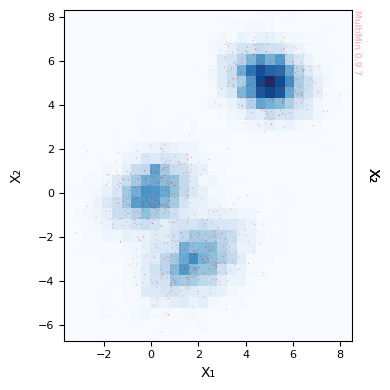

MultiMin Advantages:
  ✓ Automatic density plot creation
  ✓ Simultaneous histogram + scatter + PDF contours
  ✓ Publication-ready figures with minimal code
  ✓ Customizable properties and labels

To achieve similar visualization with sklearn would require:
  • Manual creation of DensityPlot grid
  • Manual computation of PDF on grid
  • Manual histogram and contour plotting
  • ~30-50 lines of matplotlib code


In [62]:
# Use MultiMin's built-in plot_fit method with histogram and scatter
fig = F_comparison.plot_fit(
    properties=["X₁", "X₂"],
    hargs=dict(bins=30, cmap='Blues'),
    sargs=dict(s=0.5, edgecolor='None', color='red', alpha=0.5),
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_multimin_advanced_viz.png', dpi=150, bbox_inches='tight')
plt.show()

print("MultiMin Advantages:")
print("  ✓ Automatic density plot creation")
print("  ✓ Simultaneous histogram + scatter + PDF contours")
print("  ✓ Publication-ready figures with minimal code")
print("  ✓ Customizable properties and labels")
print()
print("To achieve similar visualization with sklearn would require:")
print("  • Manual creation of DensityPlot grid")
print("  • Manual computation of PDF on grid")
print("  • Manual histogram and contour plotting")
print("  • ~30-50 lines of matplotlib code")

### Performance Benchmark

Let's compare performance across different dataset sizes:

Running performance benchmark...
Loading a FitCMND object.
Number of gaussians: 2
Number of variables: 2
Number of dimensions: 4
Number of samples: 100
Log-likelihood per point (-log L/N): 3.085243027255755
n= 100 | sklearn: 0.0175s | multimin: 0.1997s | ratio:  0.09x
Loading a FitCMND object.
Number of gaussians: 2
Number of variables: 2
Number of dimensions: 4
Number of samples: 500
Log-likelihood per point (-log L/N): 3.140920617350801
n= 500 | sklearn: 0.0035s | multimin: 0.1612s | ratio:  0.02x
Loading a FitCMND object.
Number of gaussians: 2
Number of variables: 2
Number of dimensions: 4
Number of samples: 1000
Log-likelihood per point (-log L/N): 2.985210713057362
n=1000 | sklearn: 0.0029s | multimin: 0.1115s | ratio:  0.03x
Loading a FitCMND object.
Number of gaussians: 2
Number of variables: 2
Number of dimensions: 4
Number of samples: 2000
Log-likelihood per point (-log L/N): 2.951357820986695
n=2000 | sklearn: 0.0067s | multimin: 0.1228s | ratio:  0.05x


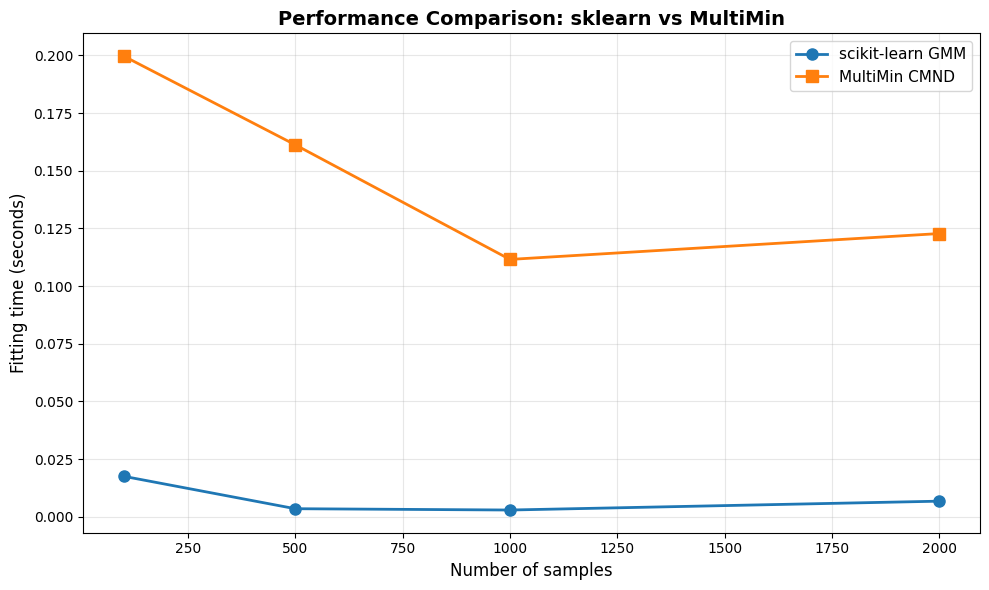


✓ Benchmark complete
Average speed ratio (sklearn/multimin): 0.05x


In [63]:
# Benchmark with different sample sizes
sample_sizes = [100, 500, 1000, 2000]
results = {'n_samples': [], 'sklearn_time': [], 'multimin_time': []}

print("Running performance benchmark...")
print("=" * 60)

for n in sample_sizes:
    # Generate data
    data_bench = np.random.multivariate_normal([0, 0], [[1, 0.3], [0.3, 1]], size=n)
    
    # Benchmark sklearn
    t0 = time.time()
    gmm_bench = GaussianMixture(n_components=2, random_state=42)
    gmm_bench.fit(data_bench)
    t_sklearn = time.time() - t0
    
    # Benchmark multimin
    t0 = time.time()
    F_bench = mn.FitCMND(data_bench, ngauss=2)
    F_bench.fit_data(data_bench, verbose=0, options={'maxiter': 200})
    t_multimin = time.time() - t0
    
    results['n_samples'].append(n)
    results['sklearn_time'].append(t_sklearn)
    results['multimin_time'].append(t_multimin)
    
    print(f"n={n:4d} | sklearn: {t_sklearn:6.4f}s | multimin: {t_multimin:6.4f}s | ratio: {t_sklearn/t_multimin:5.2f}x")

print("=" * 60)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results['n_samples'], results['sklearn_time'], 'o-', label='scikit-learn GMM', linewidth=2, markersize=8)
ax.plot(results['n_samples'], results['multimin_time'], 's-', label='MultiMin CMND', linewidth=2, markersize=8)
ax.set_xlabel('Number of samples', fontsize=12)
ax.set_ylabel('Fitting time (seconds)', fontsize=12)
ax.set_title('Performance Comparison: sklearn vs MultiMin', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'gallery/{figprefix}_performance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Benchmark complete")
print(f"Average speed ratio (sklearn/multimin): {np.mean([s/m for s, m in zip(results['sklearn_time'], results['multimin_time'])]):.2f}x")

### Conclusion

This comparison demonstrates that:

1. **Both methods are equivalent** for fitting Gaussian mixture models with full covariance matrices
2. **scikit-learn is typically faster**, especially for large datasets (EM algorithm advantage)
3. **MultiMin provides superior visualization** and scientific analysis tools
4. **The choice depends on your use case**:
   - **Scientific research, physics applications**: MultiMin
   - **Machine learning pipelines, production**: scikit-learn
   - **Teaching and exploration**: MultiMin (better visualization)
   - **Large-scale data processing**: scikit-learn (better performance)

#### Further Reading:

- **MultiMin documentation**: https://github.com/seap-udea/multimin
- **scikit-learn GMM**: https://scikit-learn.org/stable/modules/mixture.html
- **EM algorithm**: Dempster, Laird, Rubin (1977) "Maximum Likelihood from Incomplete Data via the EM Algorithm"

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga